In [107]:
import pandas as pd
import polars as pl
import polars_ols as pls
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import statsmodels.api as sm

In [108]:
df = pl.read_parquet("pga_results_1990_to_2024.pq")

In [109]:
df = df.with_columns(
    pl.col("year").cast(int).alias("int_year"),
    pl.col("final_position").str.extract("(\d+)").cast(int).alias("int_final_position"),
    pl.when(
        pl.col("tournament_name").is_in(
            [
                "masters_tournament",
                "the_open_championship",
                "us_open",
                "the_players_championship",
            ]
        )
    )
    .then(True)
    .otherwise(False)
    .alias("is_major"),
)

# Tournament Performance

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     26.63
Date:                Wed, 26 Feb 2025   Prob (F-statistic):           1.15e-05
Time:                        21:11:04   Log-Likelihood:                -56.209
No. Observations:                  35   AIC:                             116.4
Df Residuals:                      33   BIC:                             119.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        201.4985     41.708      4.831      0.0

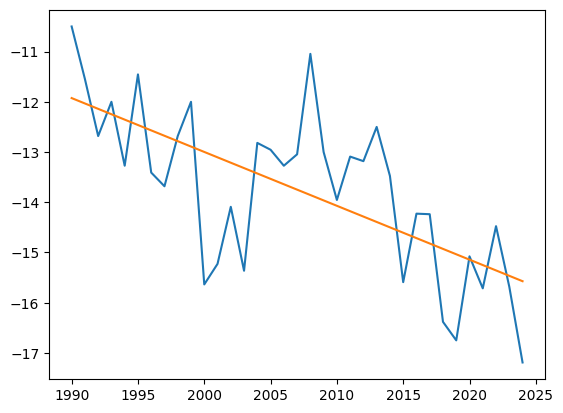

In [110]:
year_avg = (
    df.filter(pl.col("int_final_position") == 1)
    .group_by(["int_year"])
    .agg([pl.col("total_relative").mean()])
    .sort(by="int_year")
)

x, y = year_avg["int_year"].to_numpy(), year_avg["total_relative"].to_numpy()
x = sm.tools.add_constant(x)

lr = sm.regression.linear_model.OLS(y, x).fit()

print(lr.summary())

plt.plot(x[:, 1], y)
plt.plot(x[:, 1], lr.predict(x))

plt.show()

In [111]:
df.filter([pl.col("int_final_position") == 1]).group_by(
    ["tournament_name", "int_year"]
).agg([pl.col("total_relative").mean()]).group_by(["tournament_name"]).agg(
    [
        pl.col("total_relative").least_squares.ols(
            pl.col("int_year").alias("x"), mode="coefficients", add_intercept=True
        )
    ]
).unnest(
    "coefficients"
).rename(
    {"x": "coef", "const": "intercept"}
).sort(
    by="coef", descending=True
).head(
    10
)

tournament_name,coef,intercept
str,f64,f64
"""valero_texas_open""",0.138925,-295.093318
"""arnold_palmer_invitational_pre…",0.122689,-259.122689
"""the_memorial_tournament_presen…",0.082073,-178.548739
"""cognizant_classic_in_the_palm_…",0.07591,-164.009244
"""masters_tournament""",-0.008314,5.74226
"""texas_childrens_houston_open""",-0.031322,48.087468
"""charles_schwab_challenge""",-0.033333,53.585714
"""pga_championship""",-0.043978,77.405882
"""the_players_championship""",-0.072005,131.36786


# Player Performance

In [ ]:
df.group_by(["player", "int_year"]).agg(
    [pl.col("total_relative").mean().alias("avg_score")]
).group_by(["player"]).agg(
    [
        pl.col("avg_score").least_squares.ols(
            pl.col("int_year"), mode="coefficients", add_intercept=True
        ),
        pl.col("int_year").min().alias("first_year"),
        pl.col("int_year").max().alias("last_year"),
        pl.col("int_year").n_unique().alias("years_active"),
    ]
).unnest(
    "coefficients"
).rename(
    {"int_year": "coef", "const": "intecept"}
).filter(
    pl.col("years_active") > 5
).sort(
    by="coef"
)

player,coef,intecept,first_year,last_year,years_active
str,f64,f64,i64,i64,u32
"""Kevin Yu""",-3.446929,6970.442926,2018,2024,6
"""Lucas Herbert""",-2.489881,5035.86131,2018,2024,7
"""Sam Burns""",-2.36565,4780.583128,2015,2024,9
"""Dean Burmester""",-2.184265,4419.374741,2018,2024,6
"""Cole Hammer""",-2.029508,4107.131148,2015,2024,6
…,…,…,…,…,…
"""Lanny Wadkins""",1.677173,-3340.577032,1990,2001,12
"""Ron Streck""",1.693548,-3369.790323,1990,1999,9
"""Jazz Janewattananond""",2.208571,-4452.061429,2017,2023,6
